# Defining the nature and scope of the project

We are given a movie review dataset that records viewer reviews as a text message and whether that review is positive or negative. We need to seperate and analyze which texts associate mostly with positive and which to negative. This is a simple binary classification problem which we need to classify based on the bag of words for each sentiment. This project will compare different classifier models with a range of parameters and then pick the best model and parameter based on grid search with cross validation. Finally we will train, predict and evaluate using the best model.

## Importing Necessary Libraries

In [1]:
from time import time
start=time()

import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt 


from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

## Loading and Exploring Dataset

In [2]:
df=pd.read_csv('IMDB Dataset.csv')

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data Visualization

In [4]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

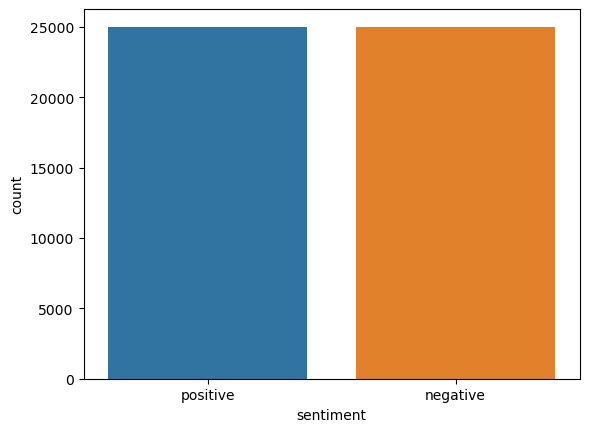

In [5]:

sns.countplot(x='sentiment',data=df)

## Preprocessing Data

In [6]:
positive_review=list(df[df['sentiment']=='positive']['review'])
negative_review=list(df[df['sentiment']=='negative']['review'])

In [7]:

stopwords=set(STOPWORDS)
# stopwords

In [8]:
def create_cloud(string, title=None):
    cloud = WordCloud(height=1080, 
                      width=1920, 
                      background_color='white', 
                      min_font_size=10, 
                      stopwords=STOPWORDS).generate(string)
    plt.figure(figsize=(10,20))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    if title:
        plt.title(title, fontdict={'fontsize':24})
    plt.show()

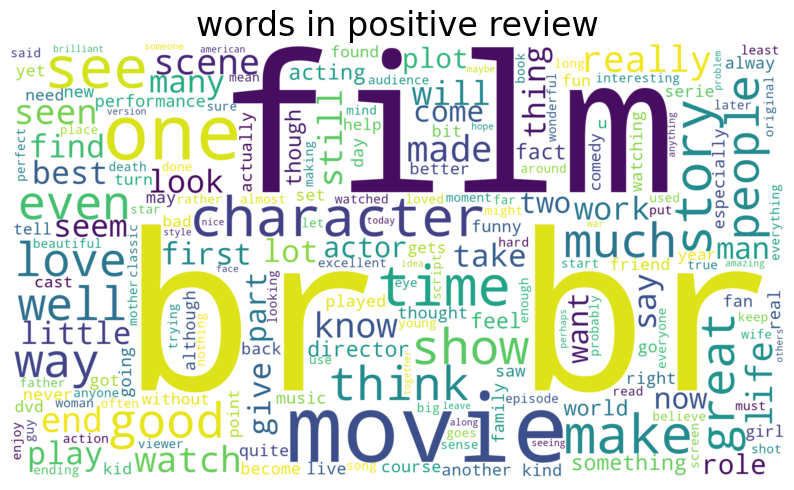

In [9]:
create_cloud(' '.join(positive_review).lower(),'words in positive review')

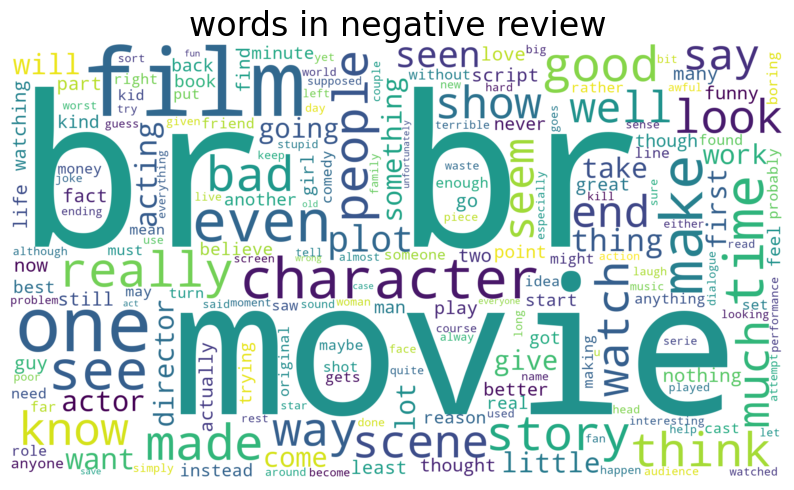

In [10]:
create_cloud(' '.join(negative_review).lower(),'words in negative review')

In [11]:
def text_processing(data):
    
    def decontracted(phrase):
        # specific
        phrase= re.sub(r'<br /><br />',' ',phrase)
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r'"', " ", phrase)
        return phrase
    stopwords=set(STOPWORDS)

    # Combining all the above stundents 
    
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    for sentance in tqdm(data['review'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e not in stopwords)
        preprocessed_reviews.append(sentance.strip())    

    porter = PorterStemmer()
    list2=[]
    for  sentence in preprocessed_reviews:
      list1=[]
      for words in sentence.split():
        list1.append(porter.stem(words))

      list2.append(' '.join(list1))
    return(list2)

In [12]:
x=text_processing(df)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:27<00:00, 1829.26it/s]


In [13]:
df['cleaned_review']=x

In [14]:
df.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one review mention watch oz episod will hooked...
1,A wonderful little production. <br /><br />The...,positive,a wonder littl production. the film techniqu u...
2,I thought this was a wonderful way to spend ti...,positive,i thought wonder way spend time hot summer wee...
3,Basically there's a family where a little boy ...,negative,basic famili littl boy (jake) think zombi clos...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visual stun film...


In [15]:
X = df['cleaned_review']
Y = df['sentiment']

In [16]:
Y = list(Y)
for i in range(len(Y)):
    if Y[i]=='positive':
        Y[i]=1
    else:
        Y[i]=0
        
df['sentiment_score']=Y

Y=df['sentiment_score']

In [17]:
df

,review,sentiment,cleaned_review,sentiment_score
0,One of the other reviewers has mentioned that ...,positive,one review mention watch oz episod will hooked...,1
1,A wonderful little production. <br /><br />The...,positive,a wonder littl production. the film techniqu u...,1
2,I thought this was a wonderful way to spend ti...,positive,i thought wonder way spend time hot summer wee...,1
3,Basically there's a family where a little boy ...,negative,basic famili littl boy (jake) think zombi clos...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visual stun film...,1
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought movi right good job. it creativ orig...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"bad plot, bad dialogue, bad acting, idiot dire...",0
49997,I am a Catholic taught in parochial elementary...,negative,i cathol taught parochi elementari school nuns...,0
49998,I'm going to have to disagree with the previou...,negative,i go disagre previou comment side maltin one. ...,0


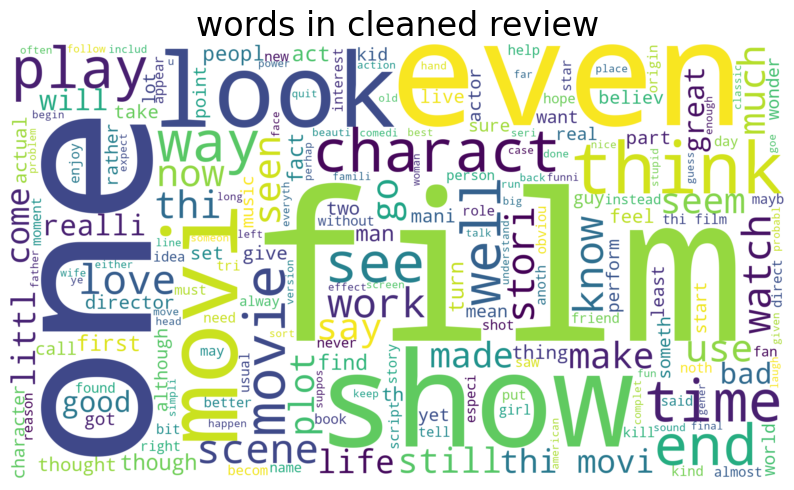

In [18]:
create_cloud(' '.join(X).lower(),'words in cleaned review')

## Splitting Data

In [19]:

X_train, X_test, y_train, y_test = train_test_split(
    X[:5000], Y[:5000], test_size=0.3, random_state=0)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3500,), (1500,), (3500,), (1500,))

In [21]:
list(y_test).count(1)

723

## Vectorizing Data to create Bag of Words

In [22]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [23]:
X_train_bow.shape,X_test_bow.shape

((3500, 30112), (1500, 30112))

## Converting vectorized data to array

In [24]:
X_train_bow = X_train_bow.toarray()
X_test_bow = X_test_bow.toarray()

## Function to compare different models

In [25]:
# List of models to try
models = [KNeighborsClassifier(),
          GaussianNB(),
          LogisticRegression(),
          RandomForestClassifier(),
          DecisionTreeClassifier(),
          GradientBoostingClassifier(),
         ]

# Hyperparameters to try
param_grid = {'KNeighborsClassifier': {'n_neighbors': [10,12,14,16,18,20,22,24,26,28,30]},
              'GaussianNB': {'var_smoothing': [.00001,.0001,.001,0.01,0.1,1,10]},
              'LogisticRegression':{'C': [.00001,.0001,.001,0.01,0.1,1,10]},
              'RandomForestClassifier': {'n_estimators': [100, 200], 'max_depth': [80,90],'max_features': [2, 3]},
              'DecisionTreeClassifier': {'max_depth': [3, 5, 70,85]},
              'GradientBoostingClassifier': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.5, 1]}
             }


# Dataframe to store results
metrics = {'Model': [], 'ATR': [], 'ATS': [], 'F1_TR': [], 'F1_TS': [], 'TIME': [], 'B_P': []}
 
# Looping through models
for i, model in enumerate(models):
    mst = time()
    
    # Get model name
    model_name = str(model).replace("()","")
    # model_names.append(model_name)
    # Perform grid search with cross-validation
    gs = GridSearchCV(estimator=model, param_grid=param_grid[model_name], cv=5, n_jobs =-1)
    gs.fit(X_train_bow, y_train)
    
    # Get best parameters
    best_params = gs.best_params_
    print(f"Best Paramenters for {model_name} is {best_params}")

    # Fit model with best parameters
    model.set_params(**best_params)
    model.fit(X_train_bow, y_train)
    
    # Append in a list for future use
    # basic_models.append(model)
    
    # Make predictions
    y_pred_train = model.predict(X_train_bow)
    y_pred_test = model.predict(X_test_bow)

    # Calculate metrics
    accuracy_train = accuracy_score(y_pred_train,y_train)
    accuracy_test = accuracy_score(y_pred_test,y_test)
    f1_train=f1_score(y_pred_train,y_train)
    f1_test = f1_score(y_pred_test,y_test)
    
    # Calculate run time for model
    met = time()
    mrt = met-mst
    minute=int(mrt/60)
    second=mrt%60
    
    # Append to DataFrame
    metrics['Model'].append(model_name)    
    metrics['ATR'].append(f"{accuracy_train:.3f}")
    metrics['ATS'].append(f"{accuracy_test:.3f}")
    metrics['F1_TR'].append(f"{f1_train:.3f}")
    metrics['F1_TS'].append(f"{f1_test:.3f}")
    metrics['TIME'].append(f"{mrt:.3f}")
    metrics['B_P'].append(best_params)
    
    metrics_df = pd.DataFrame(metrics)
    
    print(f"{model.__class__.__name__}: accuracy_train={accuracy_train:.4f} accuracy_test={accuracy_test:.4f} f1_train={f1_train:.4f}, f1_test = {f1_test:.4f}")
    if minute>=60:
        hour=int(minute/60)
        minute=minute%60
        print(f"Total execution time for {model.__class__.__name__} is : {mrt}'.")
        print(f"Which translates to: {hour} hours {minute} minutes and {second:.3f} seconds.")
    else:
        print(f"Total execution time for {model.__class__.__name__} is : {mrt}'.")
        print(f"Which translates to: {minute} minutes and {second:.3f} seconds.")
    print()


Best Paramenters for KNeighborsClassifier is {'n_neighbors': 28}
KNeighborsClassifier: accuracy_train=0.7077 accuracy_test=0.6493 f1_train=0.6808, f1_test = 0.6121
Total execution time for KNeighborsClassifier is : 198.42620086669922'.
Which translates to: 3 minutes and 18.426 seconds.

Best Paramenters for GaussianNB is {'var_smoothing': 0.0001}
GaussianNB: accuracy_train=0.9377 accuracy_test=0.6640 f1_train=0.9334, f1_test = 0.5896
Total execution time for GaussianNB is : 48.79614734649658'.
Which translates to: 0 minutes and 48.796 seconds.

Best Paramenters for LogisticRegression is {'C': 0.1}
LogisticRegression: accuracy_train=0.9894 accuracy_test=0.8567 f1_train=0.9894, f1_test = 0.8514
Total execution time for LogisticRegression is : 149.66175413131714'.
Which translates to: 2 minutes and 29.662 seconds.

Best Paramenters for RandomForestClassifier is {'max_depth': 90, 'max_features': 3, 'n_estimators': 200}
RandomForestClassifier: accuracy_train=0.9997 accuracy_test=0.7680 f1_t

## [10] Representing the findings in a table and sorting out the best model with parameters

In [26]:
# Create a PrettyTable object
table = PrettyTable()

# Add columns to the table
table.add_column("Model Name", metrics['Model'])
table.add_column("Accu_train",metrics['ATR'])
table.add_column("Accu_test",metrics['ATS'])
table.add_column("F1_train",metrics['F1_TR'])
table.add_column("F1_test",metrics['F1_TS'])
table.add_column("Time",metrics['TIME'])
table.add_column("Best parameters",metrics['B_P'])

# Set the alignment of the columns
# table.align["Model"] = "l"
# table.align["MAE"] = "r"
# table.align["MSE"] = "r"
# table.align["R2"] = "r"
# table.align["Adjusted R2"] = "r"

print(table)

+----------------------------+------------+-----------+----------+---------+-----------+-----------------------------------------------------------+
|         Model Name         | Accu_train | Accu_test | F1_train | F1_test |    Time   |                      Best parameters                      |
+----------------------------+------------+-----------+----------+---------+-----------+-----------------------------------------------------------+
|    KNeighborsClassifier    |   0.708    |   0.649   |  0.681   |  0.612  |  198.426  |                    {'n_neighbors': 28}                    |
|         GaussianNB         |   0.938    |   0.664   |  0.933   |  0.590  |   48.796  |                 {'var_smoothing': 0.0001}                 |
|     LogisticRegression     |   0.989    |   0.857   |  0.989   |  0.851  |  149.662  |                         {'C': 0.1}                        |
|   RandomForestClassifier   |   1.000    |   0.768   |  1.000   |  0.750  |   57.419  | {'max_depth': 90,

In [27]:
best=metrics_df.sort_values(by = ['ATR','F1_TR'], ascending=False).set_index('Model')
print(best)
print()
print(f"Best Model is : \033[1m{best.index[0]}\033[0m with the best parameters : \033[1m{best.iloc[0,-1]}\033[0m")

                              ATR    ATS  F1_TR  F1_TS       TIME  \
Model                                                               
RandomForestClassifier      1.000  0.768  1.000  0.750     57.419   
DecisionTreeClassifier      1.000  0.681  1.000  0.668    120.903   
LogisticRegression          0.989  0.857  0.989  0.851    149.662   
GaussianNB                  0.938  0.664  0.933  0.590     48.796   
GradientBoostingClassifier  0.931  0.811  0.932  0.809  15147.510   
KNeighborsClassifier        0.708  0.649  0.681  0.612    198.426   

                                                                          B_P  
Model                                                                          
RandomForestClassifier      {'max_depth': 90, 'max_features': 3, 'n_estima...  
DecisionTreeClassifier                                      {'max_depth': 70}  
LogisticRegression                                                 {'C': 0.1}  
GaussianNB                                     

## Finalizing the model with best results

In [28]:
final = RandomForestClassifier()
final.set_params(**best.iloc[0,-1])
final.fit(X_train_bow, y_train)

y_pred_train =final.predict(X_train_bow)
y_pred_test = final.predict(X_test_bow)

## Classification Report

In [29]:
y_train.value_counts()

0    1755
1    1745
Name: sentiment_score, dtype: int64

In [30]:
print(classification_report(y_pred_train,y_train,target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      1759
    Positive       1.00      1.00      1.00      1741

    accuracy                           1.00      3500
   macro avg       1.00      1.00      1.00      3500
weighted avg       1.00      1.00      1.00      3500



In [31]:
print(classification_report(y_pred_test,y_test,target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.81      0.74      0.77       844
    Positive       0.70      0.77      0.73       656

    accuracy                           0.76      1500
   macro avg       0.75      0.76      0.75      1500
weighted avg       0.76      0.76      0.76      1500



## Confusion Matrix

<AxesSubplot:>

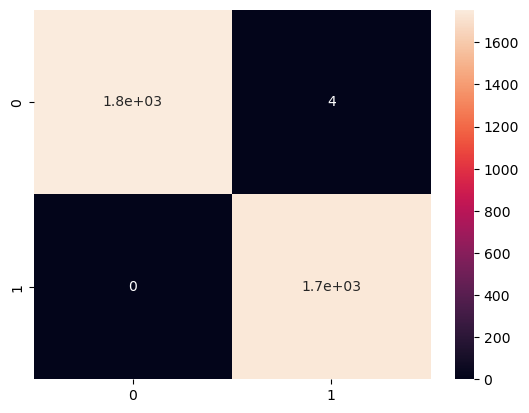

In [32]:
c= confusion_matrix(y_pred_train, y_train)
sns.heatmap(c, annot=True)

<AxesSubplot:>

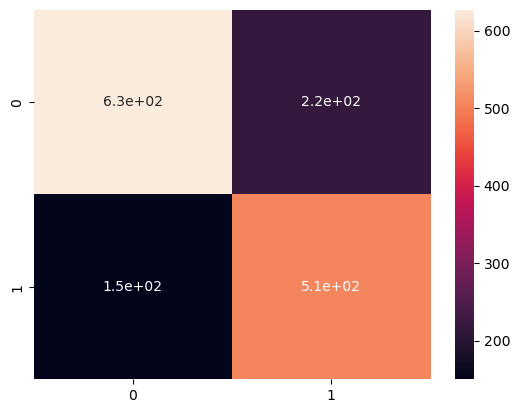

In [33]:
c= confusion_matrix(y_pred_test, y_test)
sns.heatmap(c, annot=True)

## Total Run-time

In [34]:
end=time()
total_time=end-start
minute=int(total_time/60)
second=total_time%60
if minute>=60:
    hour=int(minute/60)
    minute=minute%60
    print('Total execution time is : {}'.format(total_time))
    print(f"Which translates to: {hour} hours {minute} minutes and {second:.3f} seconds.")
else:
    print('Total execution time is : {}'.format(total_time))
    print(f"Which translates to: {minute} minutes and {second:.3f} seconds.")

Total execution time is : 15987.931946754456
Which translates to: 4 hours 26 minutes and 27.932 seconds.


## Conclusion

1) The evaluation results show that the RandomForestClassifier with parameters {'n_estimators': [100, 200], 'max_depth': [80,90],'max_features': [2, 3]} gives the best result for 1000 samples from the given data set.